#### Climatology of Buoyancy measures
1. how much BL deviation requires to kick off initialization of MCSs
2. whether BL ends at a state approaching to the climatology at that place

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.stats import linregress

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

### analysis sections

In [7]:
# read data
stats_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
ds_BL_climat = xr.open_dataset(stats_dir / 'era5_BL_measures_climatology_2002-2014.nc')
BL_MCSint = xr.open_dataset(stats_dir / 'era5_BL_measures_MCSint_2010-2019_5deg_4DType.nc')
BL_MCSend = xr.open_dataset(stats_dir / 'era5_BL_measures_MCSend_2010-2019_5deg_4DType.nc')
ds_cwv_climat = xr.open_dataset(stats_dir / 'era5_cwv_climatology_2002-2014.nc')
gpm_climat = xr.open_dataset('/neelin2020/RGMA_feature_mask/data_product/multi_year_stats/gpm_mean_monthly_2001_2019.nc')

In [5]:
deg_binsize = 2.5

# plot climatology of BL measures, seasonal
lon_bins = np.arange(0,360+deg_binsize,deg_binsize)
lat_bins = np.arange(-30,30+deg_binsize,deg_binsize)

BL_CAPE_climat = ds_BL_climat.Buoy_CAPE.interp(lat=lat_bins[:-1]+deg_binsize/2
                                             , lon=lon_bins[:-1]+deg_binsize/2)
BL_SUBSAT_climat = ds_BL_climat.Buoy_SUBSAT.interp(lat=lat_bins[:-1]+deg_binsize/2
                                             , lon=lon_bins[:-1]+deg_binsize/2)
BL_TOT_climat = ds_BL_climat.Buoy_TOT.interp(lat=lat_bins[:-1]+deg_binsize/2
                                             , lon=lon_bins[:-1]+deg_binsize/2)

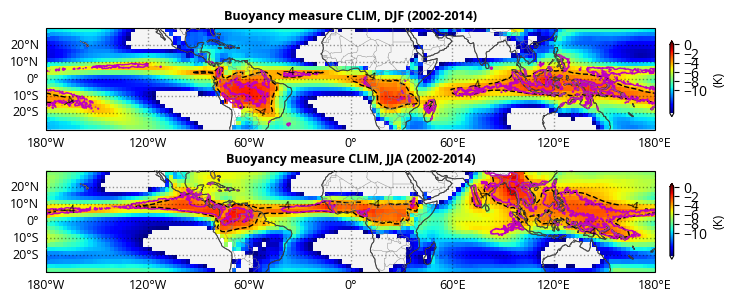

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,3),subplot_kw={'projection': ccrs.PlateCarree()})

DJF = [12,1,2]
MAM = [3,4,5]
JJA = [6,7,8]
SON = [9,10,11]

for (ax, month_sel, month_str) in zip([ax1,ax2],[DJF,JJA],
                                     ['DJF','JJA']):
    
    BL_TOT_sub = BL_TOT_climat.sel(month=month_sel).mean('month').sel(lat=slice(-30,30))
    #cf = ax.contourf(BL_TOT_sub.lon, BL_TOT_sub.lat, 340*3/9.81*BL_TOT_sub, levels=np.linspace(-10,0,11),
    #            cmap='jet', transform=ccrs.PlateCarree())
    cf = ax.pcolormesh(BL_TOT_sub.lon, BL_TOT_sub.lat, 340*3/9.81*BL_TOT_sub, vmin=-15, vmax=0,
               cmap='jet', transform=ccrs.PlateCarree())
    cf.cmap.set_under('whitesmoke')
    cbar = plt.colorbar(cf, ax=ax, shrink=0.7, pad=0.02, extend='both')
    cbar.set_label('(K)',fontsize=9)
    cbar.set_ticks([-10,-8,-6,-4,-2,0])
    
    # highlighting contour 
    cf2 = ax.contour(BL_TOT_sub.lon, BL_TOT_sub.lat, 340*3/9.81*BL_TOT_sub, levels=[-4],
               colors=['k'], linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(cf2, cf2.levels, inline=True, fontsize=8)
    
    # GPM-precip climatology
    gpm_climat_sub = gpm_climat.precipitationCal.sel(month=month_sel).mean(('month',
                                                'year')).sel(latitude=slice(-30,30),longitude=slice(0,359.75))
    ax.contour(gpm_climat_sub.longitude, gpm_climat_sub.latitude, 24*gpm_climat_sub, levels=[10], colors=['m'],
              linewidths=1)
    
    ax.set_title('Buoyancy measure CLIM, {} (2002-2014)'.format(month_str), fontsize=9, fontweight='bold')
    
    ax.coastlines(color='k',linewidth=0.7)
    ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
    ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
    ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='k', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 9, 'color': 'k'}
    gl.ylabel_style = {'size': 9, 'color': 'k'}
    
plt.tight_layout()

In [17]:
# Number of MCSs initialized at BL values

out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats')
files = sorted(list(out_dir.glob('hist2d_cape_subsat_dtype.*.all.5deg.nc')))
# sum up all samples from multiple years
for n,file in enumerate(files):
    if n == 0:
        data_bins_duration = xr.open_dataset(file).samples
    else:
        data_bins_duration = data_bins_duration + xr.open_dataset(file).samples
data_bins_duration = data_bins_duration.to_dataset()

bins_samples = data_bins_duration.sel(area_type='amean',phase='Initial').sum('duration_type').samples

BL_tot_bins = np.arange(-35,20,0.5)
BL_tot_samples = np.zeros(len(BL_tot_bins)-1)

for i in range(len(bins_samples.bins_cape)-1):
    for j in range(len(bins_samples.bins_subsat)-1):
        
        BL_tot_val = bins_samples.bins_cape[i].values - bins_samples.bins_subsat[j].values
        idx = np.argmin(abs(BL_tot_val - BL_tot_bins))
        
        BL_tot_samples[idx] += bins_samples[i,j]
        
# load 5-deg BL,tot histograms
BL_tot_climat_5deg = xr.open_dataset(out_dir / 'era5_BL_5deg_histogram.landsea.2002-2014.nc')

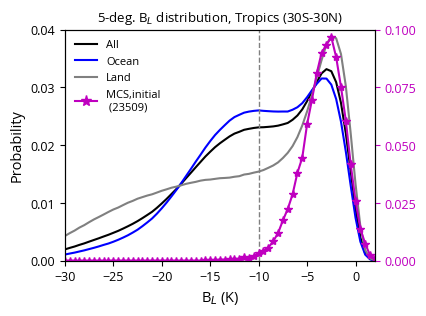

In [51]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

# 5-deg mean of hourly BL_TOT distribution: bimodal 
BL_tot_ref = BL_tot_climat_5deg.sum(('year','month','surface_type')).samples
BL_prob_ref = BL_tot_ref/BL_tot_ref.sum() # pdf of 5-deg BL over the tropics
BL_tot_oce = BL_tot_climat_5deg.sel(surface_type='ocean').sum(('year','month')).samples
BL_prob_oce = BL_tot_oce/BL_tot_oce.sum() # pdf of 5-deg BL over the tropics
BL_tot_land = BL_tot_climat_5deg.sel(surface_type='land').sum(('year','month')).samples
BL_prob_land = BL_tot_land/BL_tot_land.sum() # pdf of 5-deg BL over the tropics

ax.plot(BL_tot_climat_5deg.BL_bins, BL_prob_ref, color='k', lw=1.5);
ax.plot(BL_tot_climat_5deg.BL_bins, BL_prob_oce, color='b', lw=1.5);
ax.plot(BL_tot_climat_5deg.BL_bins, BL_prob_land, color='grey', lw=1.5);

# number of MCSs intialized at certain BL values
ax2 = ax.twinx()
ax2.plot(BL_tot_bins[:-1], BL_tot_samples/BL_tot_samples.sum(), lw=1.5, marker='*',color='m')
ax.set_xlabel('B$_{L}$ (K)', fontsize=10.5)
ax.set_ylabel('Probability', fontsize=10.5)

ax.set_ylim([0,0.04])
ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlim([-30,2])
ax2.set_ylim([0,0.1])
ax2.set_yticks(np.arange(0,0.125,0.025))
ax2.tick_params(axis='y', colors='m')
ax.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)

#ax.grid(linestyle=':', linewidth=0.5, color='grey')
ax.set_title('5-deg. B$_{L}$ distribution, Tropics (30S-30N)', fontsize=9.5)

# add reference line at -10K
ax.vlines(x=-10,ymin=0,ymax=0.04,color='grey',lw=1,linestyle='--')

# add legend
legend_elements = [Line2D([0], [0], color='k', lw=1.5, label='All'),
                   Line2D([0], [0], color='b', lw=1.5, label='Ocean'),
                   Line2D([0], [0], color='grey', lw=1.5, label='Land'),
                   Line2D([0], [0], marker='*', color='m', label='MCS,initial \n ({})'.format(int(BL_tot_samples.sum())),
                          markerfacecolor='m', markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize=8, frameon=False)
plt.show()

#### CAPE-SUBSAT histogram of 5-deg mean BL meatures at MCS phases
- read yearly outputs generated by "hist2d_cape_subsat_writeout.py"
- fractions of CAPE-SUBSAT bins at MCS phases
- PDF of 2-D histogram, reference of climatology
- land vs oceans

In [26]:
def plot_hist_cape_subsat(data_bins, area_type, sup_title):

    bins_cape = data_bins.bins_cape
    bins_subsat = data_bins.bins_subsat
    bins_sample = data_bins.sel(area_type=area_type).samples.values

    # plot histogram : fraction of occurrences at different MCS phases

    fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

    for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):

        tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
        tmp[tmp == 0] = np.nan

        cp = ax.pcolormesh(bins_subsat+0.25, bins_cape+0.25, tmp,
                        vmin=0, vmax=0.015, cmap='jet')

        # contour: fraction of occurrence
        ax.contour(bins_subsat+0.25, bins_cape+0.25, tmp,
                  levels=[0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors=['k'], linewidths=1)

        if n == 4:
            caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
            cbar = plt.colorbar(cp, cax=caxes)
            cbar.set_label('Fraction')
        ax.set_title(mcs_phase)
        ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
        ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
        ax.set_ylim([-2, 6])
        ax.set_xlim([-2, 13])

        # buoyancy reference lines
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+4, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-4, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-6, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-8, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
        ax.grid(linestyle=':', linewidth=0.5)

        # plot mean states of BL_CAPE and BL_SUBSAT
        mean_cape = np.sum((bins_cape+0.25)*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
        mean_subsat = np.sum((bins_subsat+0.25)*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

    for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):

        tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
        tmp[tmp == 0] = np.nan

        cp = ax.pcolormesh(bins_subsat+0.25, bins_cape+0.25, tmp,
                        vmin=-0.005, vmax=0.005, cmap='RdBu')
        if n == 4:
            caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
            cbar = plt.colorbar(cp, cax=caxes)
            cbar.set_label('$\Delta$Fraction (rel. to Mat.)')
        ax.set_title(mcs_phase)
        ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
        ax.set_ylabel('BL_CAPE (K)',fontsize=12)
        ax.set_ylim([-2, 6])
        ax.set_xlim([-2, 13])
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
        ax.grid(linestyle=':', linewidth=0.5)

        # buoyancy reference lines
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+4, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-4, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-6, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-8, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

        # plot mean states of BL_CAPE and BL_SUBSAT
        mean_cape = np.sum((bins_cape+0.25)*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
        mean_subsat = np.sum((bins_subsat+0.25)*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

    plt.tight_layout()
    plt.suptitle(sup_title, fontsize=16
                 , fontweight='bold', y=1.1)    

In [27]:
def plot_hist_cape_subsat_climat(data_bins, sup_title):

    bins_cape = data_bins.bins_cape
    bins_subsat = data_bins.bins_subsat
    bins_sample = data_bins.samples.values

    # plot histogram : fraction of occurrences at different MCS phases

    fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

    for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):

        tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
        tmp[tmp == 0] = np.nan

        cp = ax.pcolormesh(bins_subsat+0.25, bins_cape+0.25, tmp,
                        vmin=0, vmax=0.015, cmap='jet')

        # contour: fraction of occurrence
        ax.contour(bins_subsat+0.25, bins_cape+0.25, tmp,
                  levels=[0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors=['k'], linewidths=1)

        if n == 4:
            caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
            cbar = plt.colorbar(cp, cax=caxes)
            cbar.set_label('Fraction')
        ax.set_title(mcs_phase)
        ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
        ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
        ax.set_ylim([-2, 6])
        ax.set_xlim([-2, 13])

        # buoyancy reference lines
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+4, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-4, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-6, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-8, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

        ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
        ax.grid(linestyle=':', linewidth=0.5)

        # plot mean states of BL_CAPE and BL_SUBSAT
        mean_cape = np.sum((bins_cape+0.25)*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
        mean_subsat = np.sum((bins_subsat+0.25)*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

    for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):

        tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
        tmp[tmp == 0] = np.nan

        cp = ax.pcolormesh(bins_subsat+0.25, bins_cape+0.25, tmp,
                        vmin=-0.005, vmax=0.005, cmap='RdBu')
        if n == 4:
            caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
            cbar = plt.colorbar(cp, cax=caxes)
            cbar.set_label('$\Delta$Fraction (rel. to Mat.)')
        ax.set_title(mcs_phase)
        ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
        ax.set_ylabel('BL_CAPE (K)',fontsize=12)
        ax.set_ylim([-2, 6])
        ax.set_xlim([-2, 13])
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
        ax.grid(linestyle=':', linewidth=0.5)

        # buoyancy reference lines
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+4, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-4, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-6, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.plot(np.linspace(-2,15,17), np.linspace(-2,15,17)-8, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

        # plot mean states of BL_CAPE and BL_SUBSAT
        mean_cape = np.sum((bins_cape+0.25)*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
        mean_subsat = np.sum((bins_subsat+0.25)*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

    plt.tight_layout()
    plt.suptitle(sup_title, fontsize=16
                 , fontweight='bold', y=1.1)    

In [72]:
def plot_scatter_mode(data_bins_duration, area_type, x_lim, y_lim):
    
    # position of mode
    # read written output
    fig, ax = plt.subplots(1,1,figsize=(4,4))

    label_strings = ['SL (< 6H)','ML (6-12H)','LL (12-18H)','UL (18-24H)','UUL (>24H)']
    duration_list = ['SL','ML','LL','UL','UUL']
    ccolors=['k','y','orange','r','m']

    for (duration_type,label_string,ccolor) in zip(duration_list, label_strings, ccolors):

        bins_cape = data_bins_duration.bins_cape
        bins_subsat = data_bins_duration.bins_subsat
        
        if area_type == 'climate':
            bins_sample = data_bins_duration.sel(duration_type=duration_type).samples.values
        else:
            bins_sample = data_bins_duration.sel(duration_type=duration_type, area_type=area_type).samples.values
            

        position_arrow = []
        for n, (mcs_phase, phase_string) in enumerate(zip(['Init','Grow','Mature','Decay','End']
                                                      ,['I','','M','','E'])):

            # plot mean states of BL_CAPE and BL_SUBSAT
            mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
            mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
            if n == 0:
                ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color=ccolor, zorder=2, edgecolor='k'
                           , label=label_string)
            else:
                ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color=ccolor, zorder=2, edgecolor='k')
            position_arrow.append((mean_subsat, mean_cape))

            # MCS phase string
            ax.text(mean_subsat-0.15, mean_cape+0.02, phase_string)

        # plotting arrow between markers
        for n in range(len(position_arrow)-1):
            arrow = FancyArrowPatch(posA=position_arrow[n], posB=position_arrow[n+1], 
                                            arrowstyle='-|>', mutation_scale=8, color=ccolor)
            ax.add_patch(arrow)    

    # reference lines of buoyancy total
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2
            , linewidth=1, linestyle=':') # -2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-3, marker=None, color='grey',zorder=2
            , linewidth=1, linestyle=':') # -3 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-4, marker=None, color='grey',zorder=2
            , linewidth=1, linestyle=':') # -4 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-5, marker=None, color='grey',zorder=2
            , linewidth=1, linestyle=':') # -4 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-6, marker=None, color='grey',zorder=2
            , linewidth=1, linestyle=':') # -4 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-7, marker=None, color='grey',zorder=2
            , linewidth=1, linestyle=':') # -4 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-8, marker=None, color='grey',zorder=2
            , linewidth=1, linestyle=':') # -4 K 

    ax.legend(fontsize=9, loc='lower left')
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_xlabel('B$_{L,SUBSAT}$ (K)',fontsize=10.5)
    ax.set_ylabel('B$_{L,CAPE}$ (K)',fontsize=10.5)
    ax.set_title('Mode of 2-D joint histogram, 5-deg. Mean',fontsize=10.5, fontweight='bold')
    ax.tick_params(labelsize=9)
    ax.set_ylim([y_lim[0],y_lim[1]])
    ax.set_xlim([x_lim[0],x_lim[1]])

    # annotation for const. buoyancy lines
    ax.text(4.55, 1.62, '-3K', fontsize=9, color='k')
    ax.text(5.55, 1.62, '-4K', fontsize=9, color='k')
    ax.text(6.55, 1.62, '-5K', fontsize=9, color='k')
    ax.text(7.55, 1.62, '-6K', fontsize=9, color='k')

#### load bins_cape_subsat

In [55]:
%%time

out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist')
files = sorted(list(out_dir.glob('hist2d_cape_subsat_dtype.*.all.5deg.nc')))
# sum up all samples from multiple years
for n,file in enumerate(files):
    if n == 0:
        data_bins_all = xr.open_dataset(file).samples
    else:
        data_bins_all = data_bins_all + xr.open_dataset(file).samples
data_bins_all = data_bins_all.to_dataset()

# MCSs over oceans
files = sorted(list(out_dir.glob('hist2d_cape_subsat_dtype.*.ocean.5deg.nc')))
# sum up all samples from multiple years
for n,file in enumerate(files):
    if n == 0:
        data_bins_oce = xr.open_dataset(file).samples
    else:
        data_bins_oce = data_bins_oce + xr.open_dataset(file).samples
data_bins_oce = data_bins_oce.to_dataset()

# MCSs over oceans
files = sorted(list(out_dir.glob('hist2d_cape_subsat_dtype.*.land.5deg.nc')))
# sum up all samples from multiple years
for n,file in enumerate(files):
    if n == 0:
        data_bins_land = xr.open_dataset(file).samples
    else:
        data_bins_land = data_bins_land + xr.open_dataset(file).samples
data_bins_land = data_bins_land.to_dataset()

CPU times: user 1.28 s, sys: 69.9 ms, total: 1.35 s
Wall time: 1.4 s


In [56]:
%%time
### climatology constructed by location-dependenet monthly BL reference
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist')
files = sorted(list(out_dir.glob('hist2d_cape_subsat_dtype.*.all.climat.nc')))
# sum up all samples from multiple years
for n,file in enumerate(files):
    if n == 0:
        data_bins_ref = xr.open_dataset(file).samples
    else:
        data_bins_ref = data_bins_ref + xr.open_dataset(file).samples
data_bins_ref = data_bins_ref.to_dataset()

CPU times: user 258 ms, sys: 29 ms, total: 287 ms
Wall time: 299 ms


#### plotting section

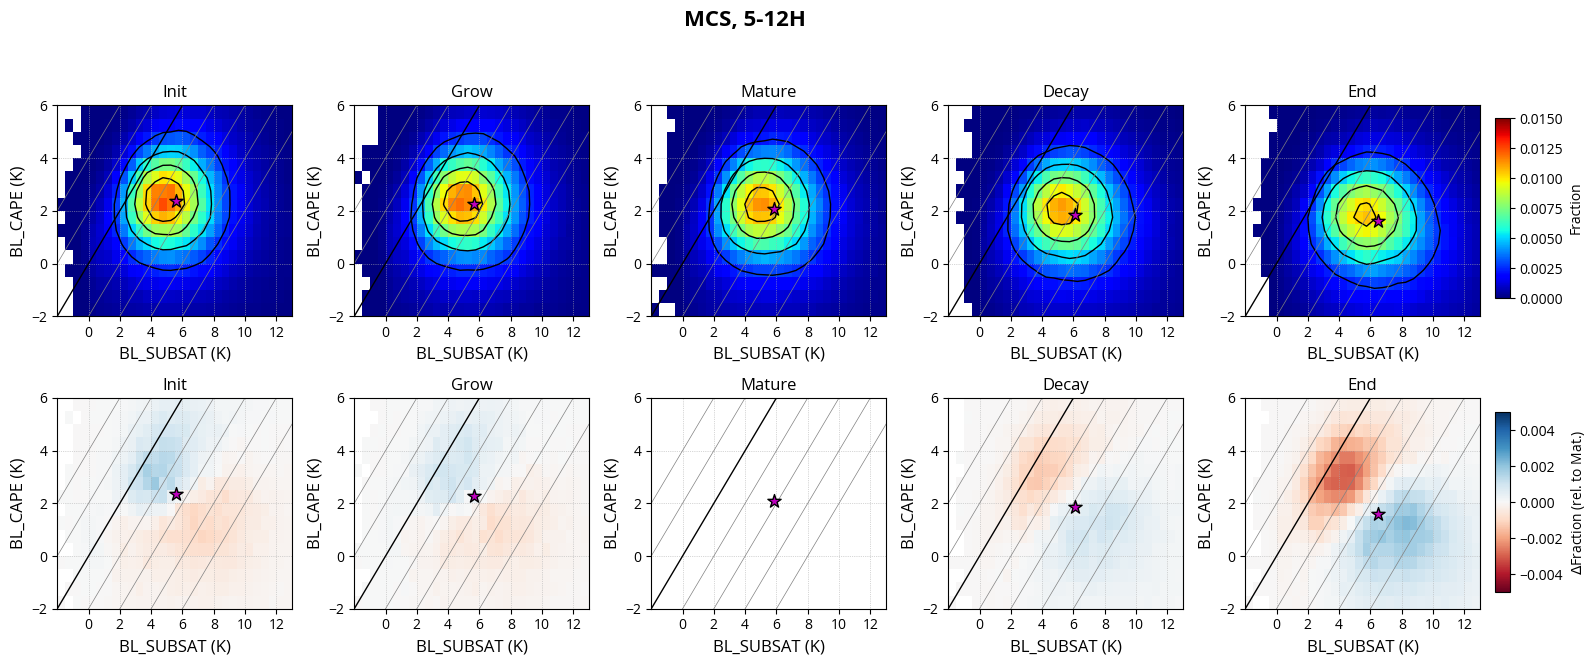

In [57]:
title_string = 'MCS, 5-12H'
tmp = data_bins_all.sel(duration_type='SL') + data_bins_all.sel(duration_type='ML')
plot_hist_cape_subsat(tmp, area_type='mcs', sup_title=title_string)

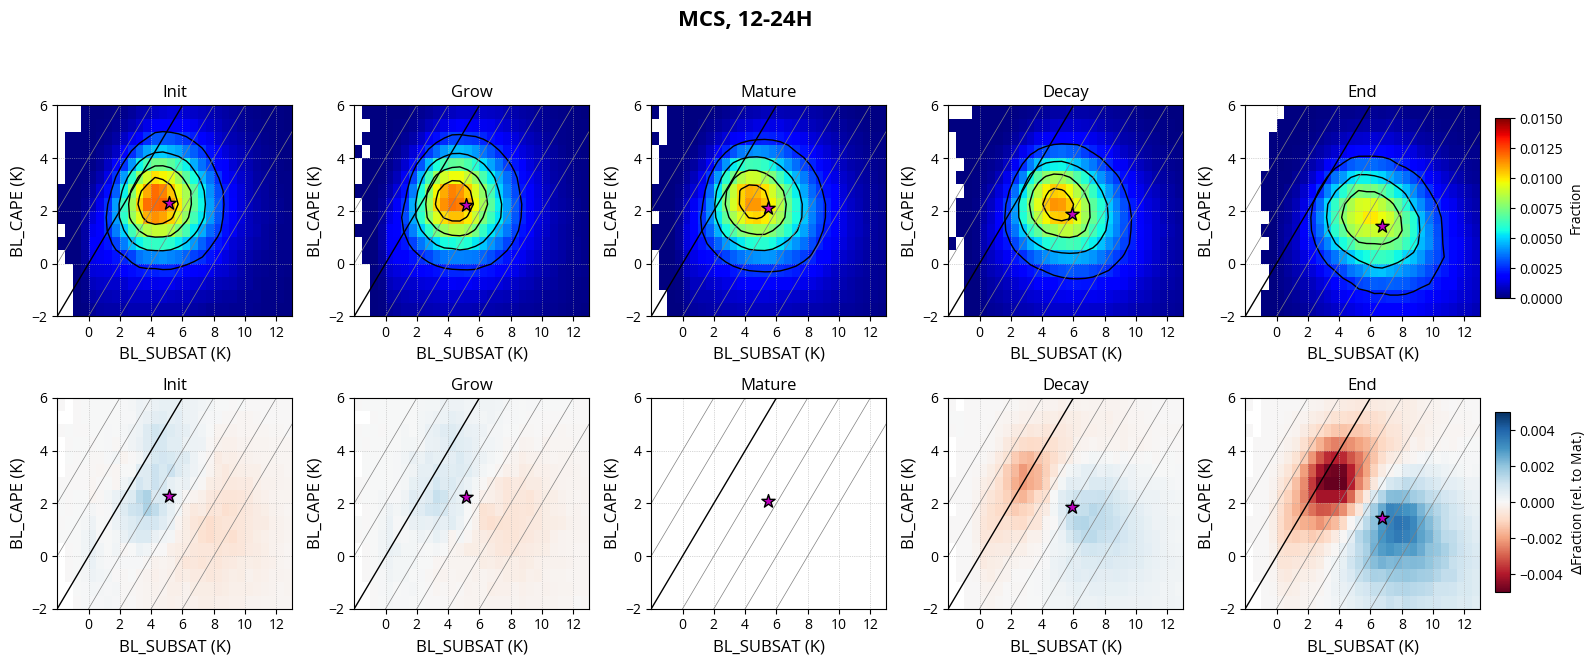

In [58]:
title_string = 'MCS, 12-24H'
tmp = data_bins_all.sel(duration_type='LL') + data_bins_all.sel(duration_type='UL')
plot_hist_cape_subsat(tmp, area_type='mcs', sup_title=title_string)

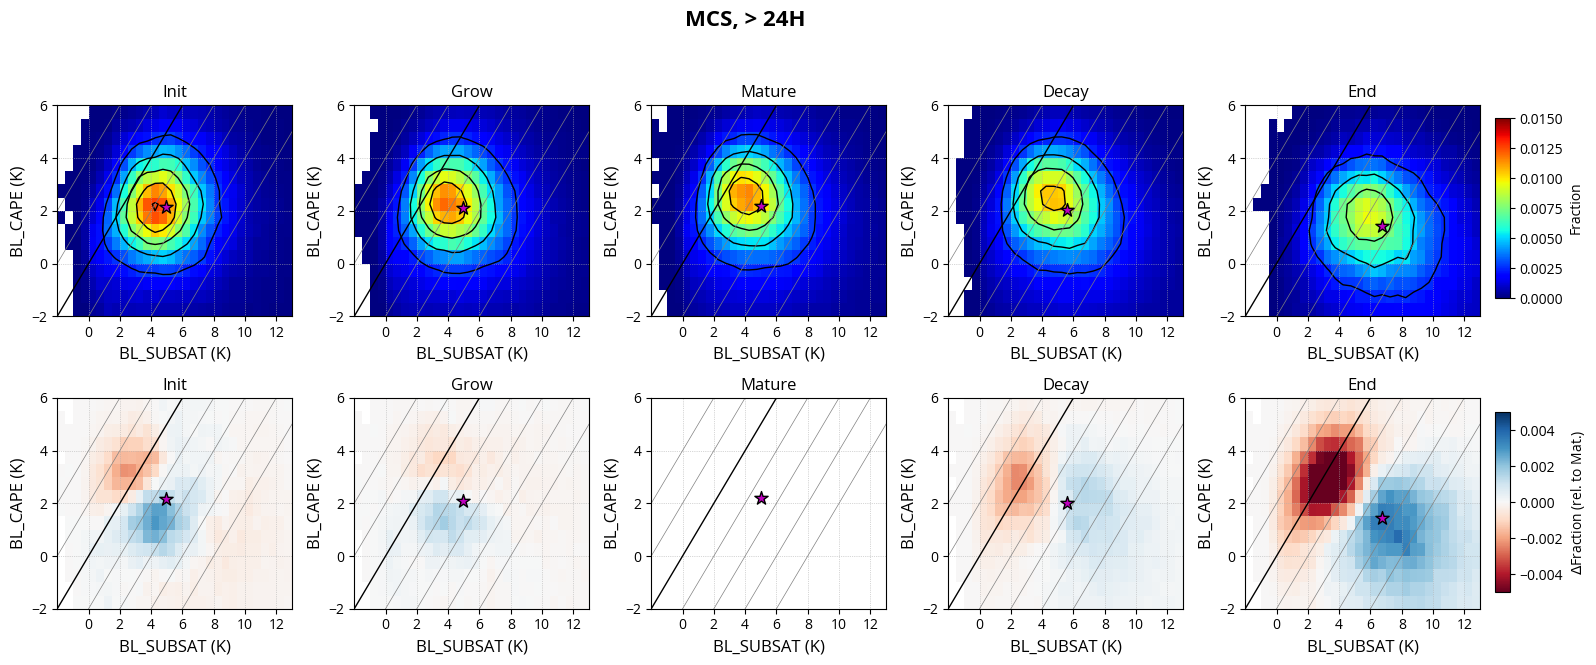

In [59]:
title_string = 'MCS, > 24H'
tmp = data_bins_all.sel(duration_type='UUL') 
plot_hist_cape_subsat(tmp, area_type='mcs', sup_title=title_string)

#### 5-deg area mean of BL, all

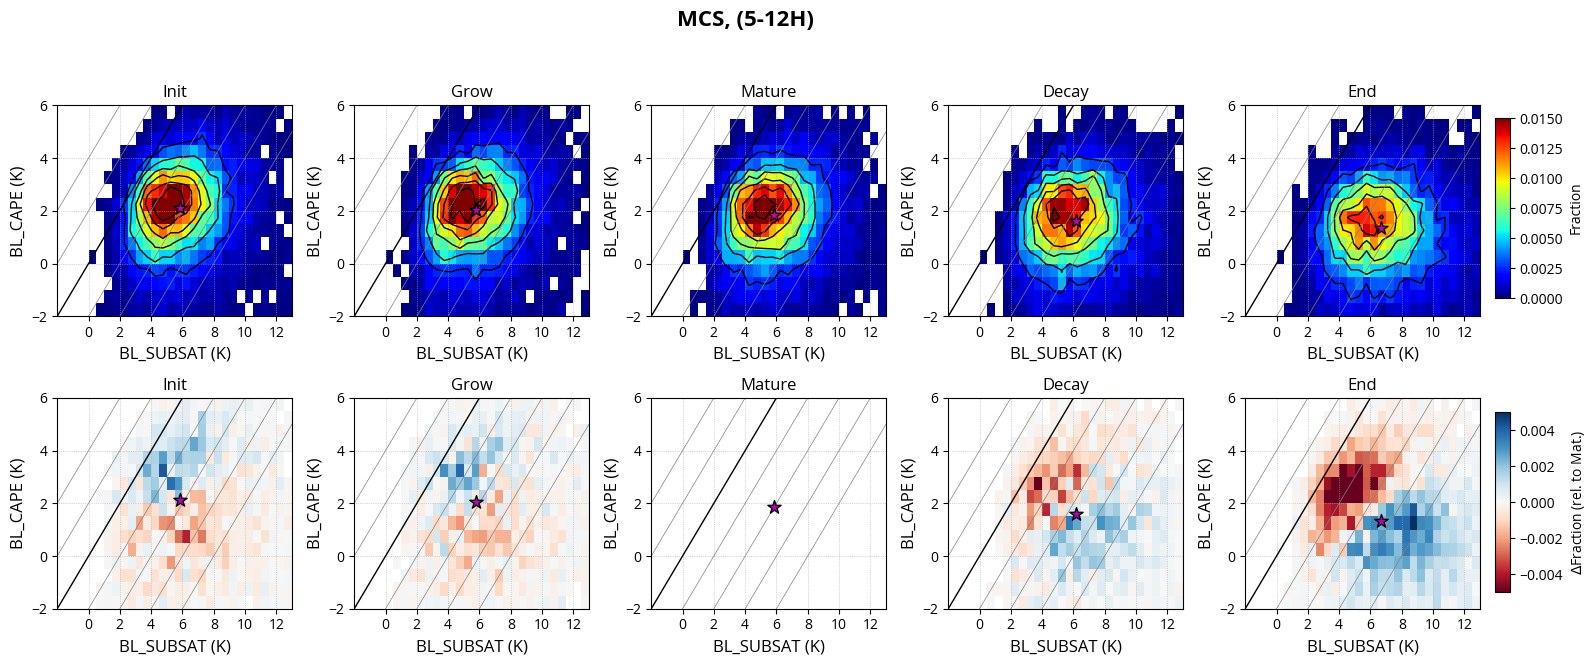

In [60]:
title_string = 'MCS, (5-12H)'
tmp = data_bins_all.sel(duration_type='SL') + data_bins_all.sel(duration_type='ML') 
plot_hist_cape_subsat(tmp, area_type='amean', sup_title=title_string)

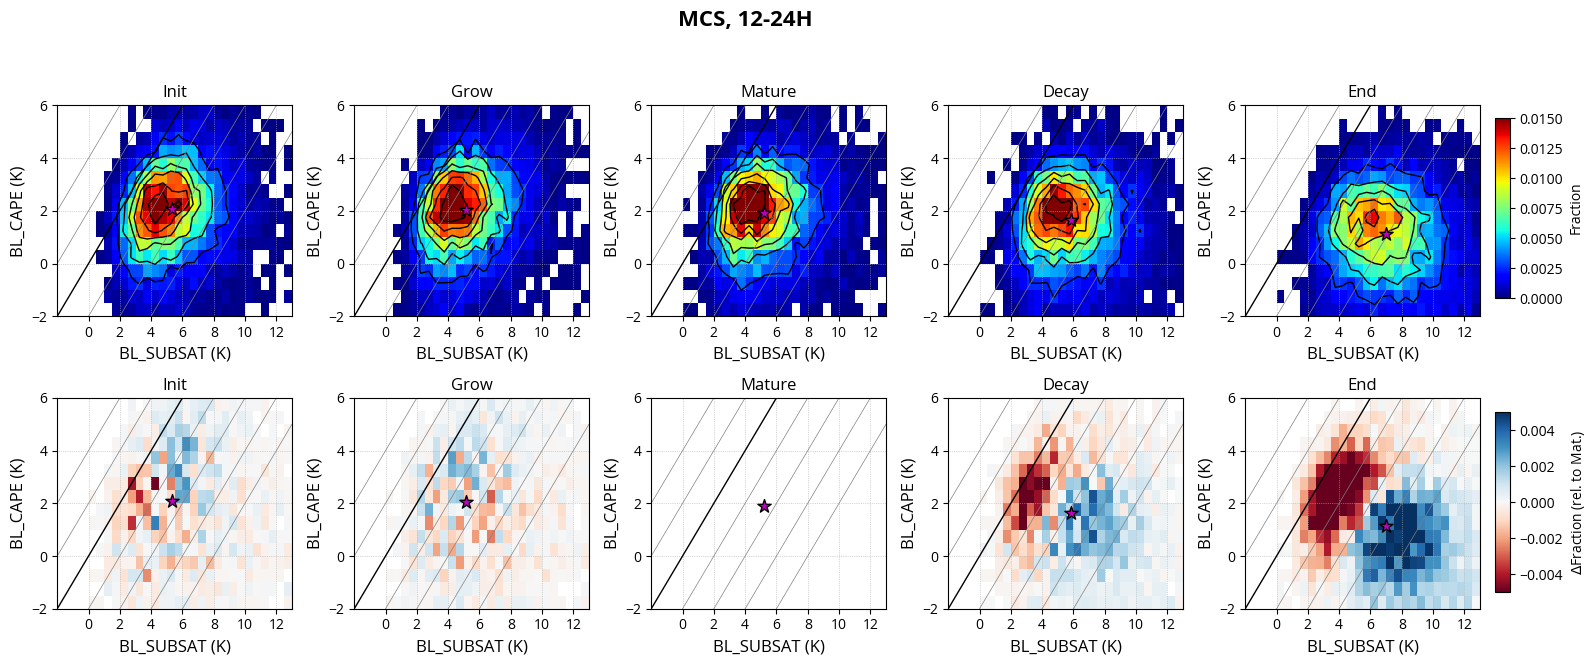

In [61]:
title_string = 'MCS, 12-24H'
tmp = data_bins_all.sel(duration_type='LL') + data_bins_all.sel(duration_type='UL')
plot_hist_cape_subsat(tmp, area_type='amean', sup_title=title_string)

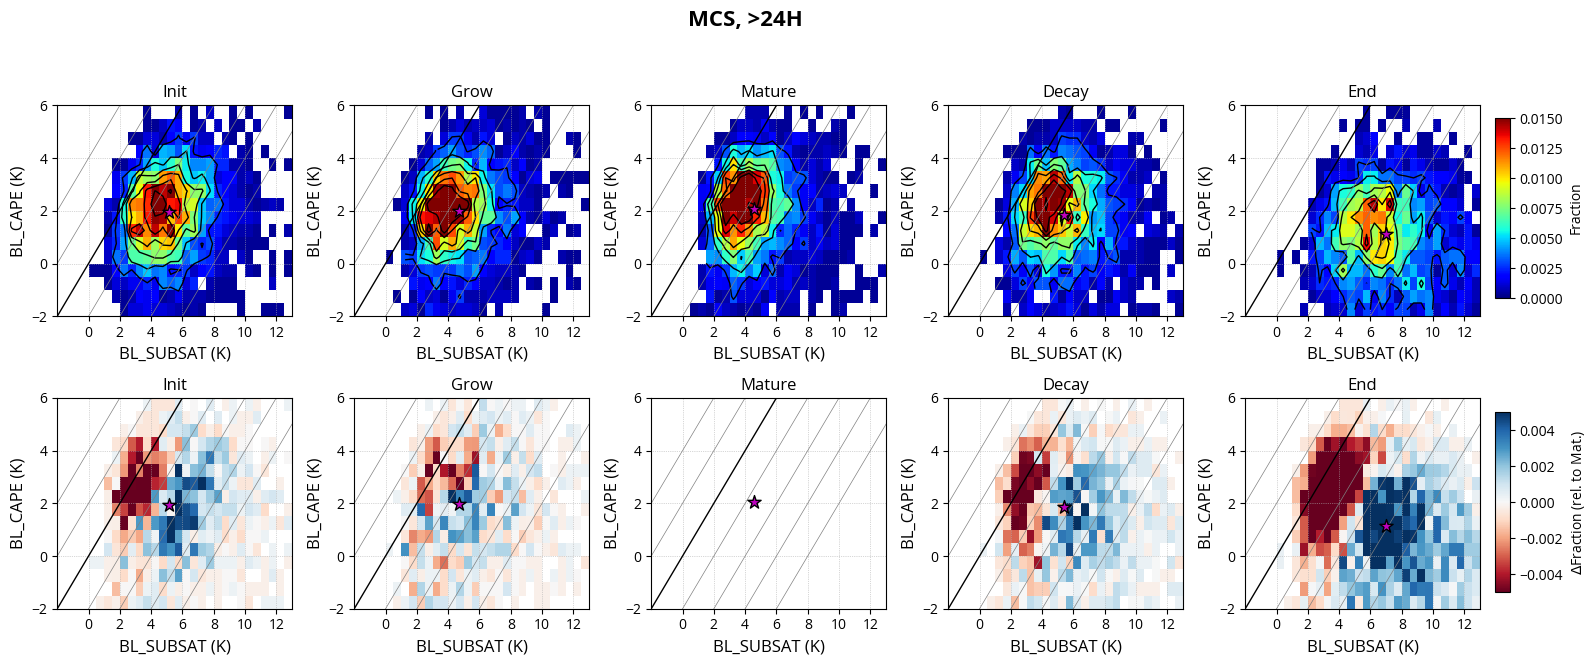

In [62]:
title_string = 'MCS, >24H'
tmp = data_bins_all.sel(duration_type='UUL')
plot_hist_cape_subsat(tmp, area_type='amean', sup_title=title_string)

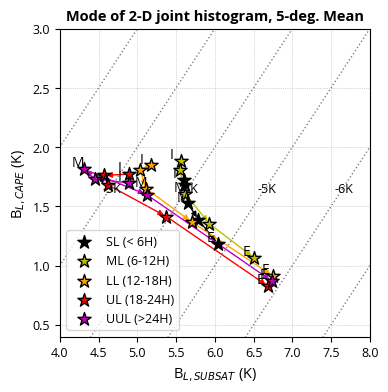

In [81]:
plot_scatter_mode(data_bins_all, area_type='amean', x_lim=[4, 8], y_lim=[0.4, 3])

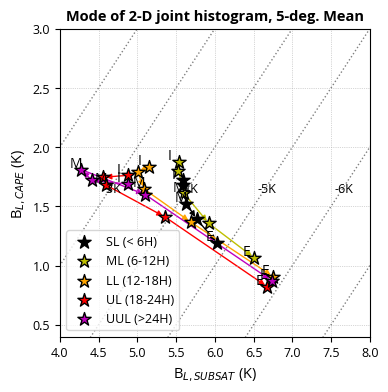

In [80]:
plot_scatter_mode(data_bins_oce, area_type='amean', x_lim=[4, 8], y_lim=[0.4, 3])

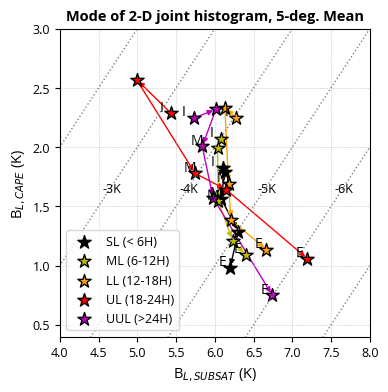

In [75]:
plot_scatter_mode(data_bins_land, area_type='amean', x_lim=[4, 8], y_lim=[0.4, 3])

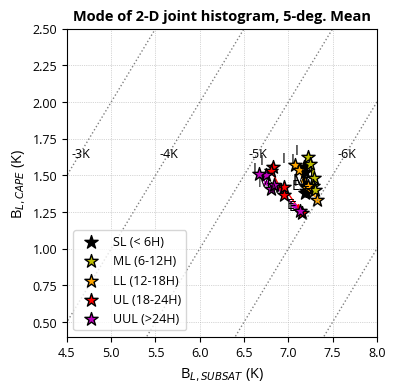

In [77]:
plot_scatter_mode(data_bins_oce, area_type='env', x_lim=[4.5, 8], y_lim=[0.4, 2.5])

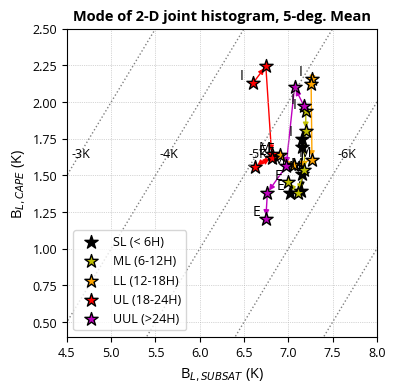

In [78]:
plot_scatter_mode(data_bins_land, area_type='env', x_lim=[4.5, 8], y_lim=[0.4, 2.5])

#### climatology reference

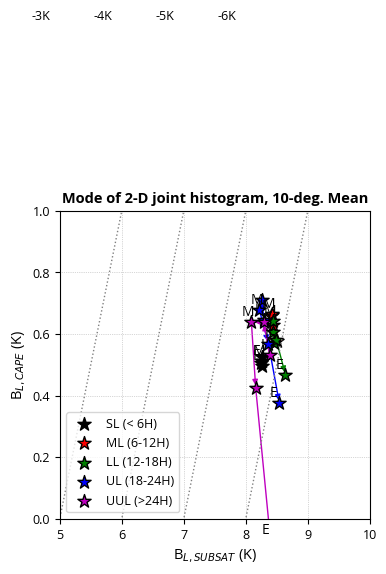

In [45]:
plot_scatter_mode(data_bins_ref, area_type='climate', x_lim=[5,10], y_lim=[0, 1.])